In [ ]:
# Install required libraries
!pip install numpy pandas scikit-learn keras

# Import libraries
import os
from glob import glob

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.optimizers.legacy import Adam
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

In [ ]:
X_train = np.load("/content/drive/MyDrive/main project/256_192_train.npy")
y_train = np.load("/content/drive/MyDrive/main project/train_labels.npy")
X_val = np.load("/content/drive/MyDrive/main project/256_192_val.npy")
y_val = np.load("/content/drive/MyDrive/main project/val_labels.npy")

In [ ]:
# Convert labels to categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:

# Load DenseNet201 with pre-trained weights
pre_trained_model = DenseNet201(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

74836368/74836368 [==============================] - 5s 0us/step


In [ ]:

# Freeze layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:

# Build custom model on top of DenseNet201
last_layer = pre_trained_model.get_layer('relu')
last_output = last_layer.output



In [ ]:
x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)

In [ ]:

model = Model(pre_trained_model.input, x)


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 198, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 96, 128, 64)          9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 96, 128, 64)          256       ['conv1/conv[0][0]']      

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()

val_datagen.fit(X_val)

In [ ]:
# Training
batch_size = 32
epochs = 3

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val),
    verbose=1,
    steps_per_epoch=(X_train.shape[0] // batch_size),
    validation_steps=(X_val.shape[0] // batch_size)
)

Epoch 1/3
253/253 [==============================] - 163s 534ms/step - loss: 1.3161 - accuracy: 0.6335 - val_loss: 0.9662 - val_accuracy: 0.6897
Epoch 2/3
253/253 [==============================] - 127s 503ms/step - loss: 0.9142 - accuracy: 0.6917 - val_loss: 0.8412 - val_accuracy: 0.6931
Epoch 3/3
253/253 [==============================] - 128s 505ms/step - loss: 0.8432 - accuracy: 0.6986 - val_loss: 0.8377 - val_accuracy: 0.7031


In [ ]:
# Unfreeze some layers
for layer in pre_trained_model.layers:
    layer.trainable = True

In [ ]:
# Compile the model again
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.000001,
    cooldown=2
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 198, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 96, 128, 64)          9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 96, 128, 64)          256       ['conv1/conv[0][0]']      

In [ ]:
# Training with unfrozen layers
batch_size = 32
epochs = 20

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val),
    verbose=1,
    steps_per_epoch=(X_train.shape[0] // batch_size),
    validation_steps=(X_val.shape[0] // batch_size),
    callbacks=[learning_rate_reduction]
)

Epoch 1/20
253/253 [==============================] - 206s 694ms/step - loss: 0.7710 - acc: 0.7313 - val_loss: 0.7247 - val_acc: 0.7411 - lr: 1.0000e-04
Epoch 2/20
253/253 [==============================] - 169s 666ms/step - loss: 0.5856 - acc: 0.7923 - val_loss: 0.6933 - val_acc: 0.7902 - lr: 1.0000e-04
Epoch 3/20
253/253 [==============================] - 175s 693ms/step - loss: 0.4908 - acc: 0.8187 - val_loss: 0.6080 - val_acc: 0.7991 - lr: 1.0000e-04
Epoch 4/20
253/253 [==============================] - 193s 764ms/step - loss: 0.4310 - acc: 0.8426 - val_loss: 0.6128 - val_acc: 0.7924 - lr: 1.0000e-04
Epoch 5/20
253/253 [==============================] - 167s 661ms/step - loss: 0.3917 - acc: 0.8615 - val_loss: 0.6044 - val_acc: 0.7958 - lr: 1.0000e-04
Epoch 6/20
253/253 [==============================] - 168s 662ms/step - loss: 0.3475 - acc: 0.8726 - val_loss: 0.5481 - val_acc: 0.8136 - lr: 1.0000e-04
Epoch 7/20
253/253 [==============================] - 166s 657ms/step - loss: 0.32

In [ ]:

# Evaluate on validation set
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))


29/29 [==============================] - 6s 213ms/step - loss: 0.4969 - acc: 0.8891
Validation: accuracy = 0.889135  ;  loss_v = 0.496931


In [ ]:
X_test = np.load("/content/drive/MyDrive/main project/256_192_test.npy")

In [ ]:
y_test = np.load("/content/drive/MyDrive/main project/test_labels.npy")
y_test = to_categorical(y_test)

In [ ]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 8s 227ms/step - loss: 0.5508 - acc: 0.8743
Test: accuracy = 0.874251  ;  loss = 0.550768


In [ ]:
model.save("DenseNetFull.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training and validation loss')

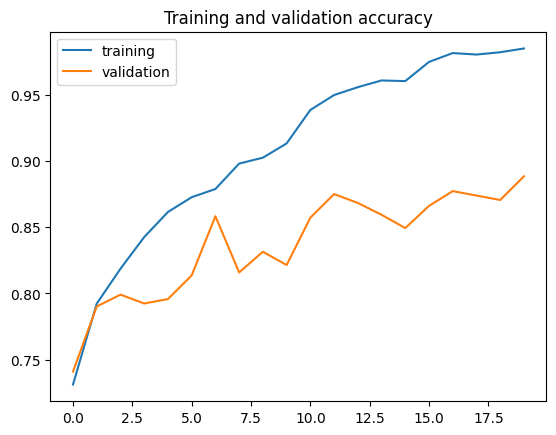

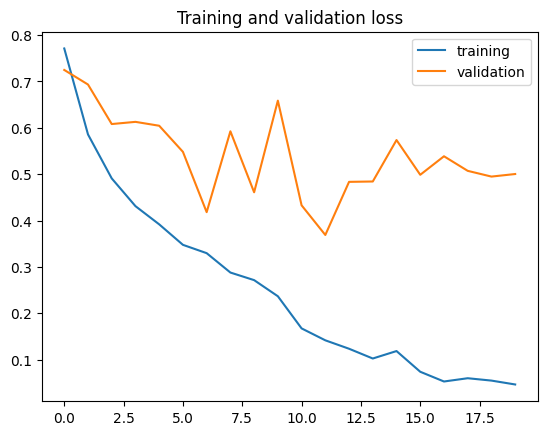

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

32/32 [==============================] - 7s 131ms/step


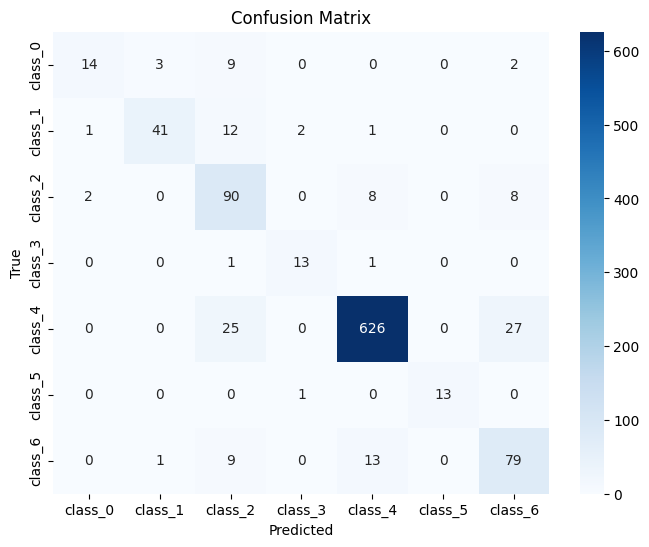

              precision    recall  f1-score   support

     class_0       0.82      0.50      0.62        28
     class_1       0.91      0.72      0.80        57
     class_2       0.62      0.83      0.71       108
     class_3       0.81      0.87      0.84        15
     class_4       0.96      0.92      0.94       678
     class_5       1.00      0.93      0.96        14
     class_6       0.68      0.77      0.72       102

    accuracy                           0.87      1002
   macro avg       0.83      0.79      0.80      1002
weighted avg       0.89      0.87      0.88      1002



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
# Load the trained model
model = load_model("/content/drive/MyDrive/DenseNetFull.h5")

# Assuming X_test and y_test are loaded in your script
X_test = np.load("/content/drive/MyDrive/main project/256_192_test.npy")
y_test = np.load("/content/drive/MyDrive/main project/test_labels.npy")
y_test_categorical = to_categorical(y_test)

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels back to categorical labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_categorical, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_names = ["class_0", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6"]

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
#class_names = ["class_0", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6"]
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))
